**DATA PIPELINE CLASS**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


data = pd.read_csv(r"..\data\student_portuguese_clean.csv")

#Pipeline class has methods that can prepare the data for further use

class Pipeline:
    
    def __init__(self, data, prediction_column):
        self.data = data
        self.prediction_column = prediction_column
    def getX(self):
        return self.data.drop(self.prediction_column, axis=1).to_numpy()
    def getY(self):
        return self.data[self.prediction_column].to_numpy()
    def getNumericalColumns(self):
        return self.data.select_dtypes(include=['float64', 'int64']).columns
    def getCorrelationMatrix(self):
        correlation_matrix = self.data[self.getNumericalColumns()].corr()
        plt.figure(figsize=(8, 6))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
        plt.title('Correlation Matrix of Numerical Columns')
        plt.show()
    def getDummies(self):
        #Represent non-numerical features numerically
        numerical_columns = self.getNumericalColumns()
        non_numerical_columns = self.data.columns.difference(numerical_columns)
    
        return pd.get_dummies(self.data, columns=non_numerical_columns, drop_first=False)

    



**LINEAR REGRESSION MODEL**


Index(['age', 'class_failures', 'family_relationship', 'free_time', 'social',
       'weekday_alcohol', 'weekend_alcohol', 'health', 'absences', 'grade_1',
       'grade_2', 'final_grade', 'activities_yes', 'address_type_Urban',
       'extra_paid_classes_yes', 'family_size_Less than or equal to 3',
       'family_support_yes', 'father_education_higher education',
       'father_education_none',
       'father_education_primary education (4th grade)',
       'father_education_secondary education', 'father_job_health',
       'father_job_other', 'father_job_services', 'father_job_teacher',
       'guardian_mother', 'guardian_other', 'higher_ed_yes',
       'internet_access_yes', 'mother_education_higher education',
       'mother_education_none',
       'mother_education_primary education (4th grade)',
       'mother_education_secondary education', 'mother_job_health',
       'mother_job_other', 'mother_job_services', 'mother_job_teacher',
       'nursery_school_yes', 'parent_status_Liv

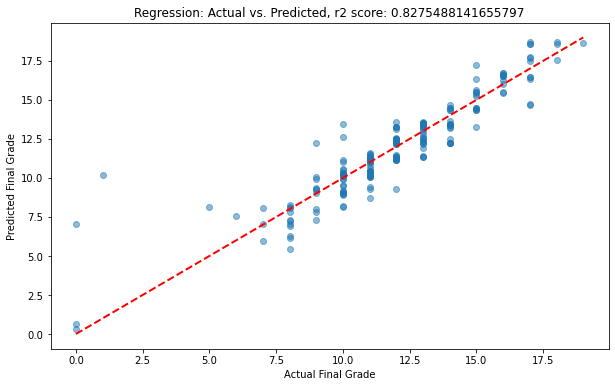

In [46]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV


pipeline = Pipeline(data.drop("student_id", axis=1), "final_grade")

dummies = pipeline.getDummies()

print(dummies.columns)

X = dummies.drop("final_grade", axis = 1)
y = dummies["final_grade"]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#Defining the models and fitting them to train data
lassoCV = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
elasticnetCV = ElasticNetCV(cv=5, random_state=0).fit(X_train, y_train)
ridgeCV = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)

#Making predictions
ypred_lasso = lassoCV.predict(X_test)
ypred_elasticnet = elasticnetCV.predict(X_test)
ypred_ridge = ridgeCV.predict(X_test)

#Getting the r2 score
r2_lasso = metrics.r2_score(y_test, ypred_lasso)
r2_elasticnet = metrics.r2_score(y_test, ypred_elasticnet)
r2_ridge = metrics.r2_score(y_test, ypred_ridge)

#A simple scatter plot of ytest and ypred, a good model should follow a diagonal line y=x
def makeScatter(ytest, ypred, r2score):
    plt.figure(figsize=(10, 6))
    plt.scatter(ytest, ypred, alpha=0.5)
    plt.plot([min(ytest), max(ytest)], [min(ytest), max(ytest)], '--', color='red', linewidth=2)  # Diagonal line
    plt.title(f'Regression: Actual vs. Predicted, r2 score: {r2score}')
    plt.xlabel('Actual Final Grade')
    plt.ylabel('Predicted Final Grade')
    plt.show()

makeScatter(y_test,ypred_lasso, r2_lasso)



